## Bagging

Es un metaalgoritmo de aprendizaje automático diseñado para mejorar la estabilidad y precisión de algoritmos de aprendizaje automático usados en clasificación estadística y regresión. Además reduce la varianza y ayuda a evitar el sobreajuste. Aunque es usualmente aplicado a métodos de árboles de decisión, puede ser usado con cualquier tipo de método. El empaquetado es un caso especial del promediado de modelos.



In [22]:
# Importamos las librerías necesarias

import numpy as np
import pandas as pd
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
# Representaciones graficas locales

%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

# Obviamos los errores de actualización 

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# Ponemos la semilla
np.random.seed(0)

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [23]:
# Importamos la función de limpieza y preprocesado de datos
import frauddef # con solo las variables de research

In [24]:
# Importamos el dataset 
df = pd.read_csv('Explor_uscecchini28.csv')

In [25]:
# Establecemos las variables X e Y
X_train_nm, X_test_nm, y_train_nm, y_test_nm, X_train_sm, X_test_sm, y_train_sm, y_test_sm = frauddef.limpieza(df)

In [26]:
# Escalamos las variables con MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_nm = scaler.fit_transform(X_train_nm)
X_test_nm  = scaler.transform(X_test_nm)

##### Logistic Regression with Bagging

La clasificación binaria de eventos se puede realizar a partir de un modelo regresión logística donde se utiliza la expresión
$$
F(x) = \frac{1}{1 + e^{-x}}
$$

In [27]:
# Selección de parámetros de LR con la función "GridSearchCV"
lr = LogisticRegression()


grid_param = dict(penalty = ["l1","l2"], C= np.logspace(-3,3,7))# l1 lasso l2 ridge

# establecemos la validación cruzado con 2 divisiones, los parámetros y el uso de núcleos de memoria.
bag_lr_grid = GridSearchCV(lr, grid_param, cv = 2, n_jobs = -1, return_train_score= True)

#train grid model
bag_lr_grid.fit(X_train_nm, y_train_nm)

GridSearchCV(cv=2, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True)

In [28]:
# Mejores parámetros
print("Best Parameters for Bagging Classifier: ", bag_lr_grid.best_params_)

Best Parameters for Bagging Classifier:  {'C': 1000.0, 'penalty': 'l2'}


In [29]:
# Construcción del modelo Bagging
lr =LogisticRegression(penalty= bag_lr_grid.best_params_['penalty']
                        , C=bag_lr_grid.best_params_['C'])

bag = BaggingClassifier(lr)

grid_param = dict(max_samples=[0.1, 0.5, 0.7, 0.9, 1.0],
                  n_estimators= [100,250, 500, 1000])

#grid model
bag_lr_grid = GridSearchCV(bag, grid_param, cv = 2, n_jobs = -1, return_train_score= True)

#train grid model
bag_lr_grid.fit(X_train_nm, y_train_nm)

GridSearchCV(cv=2,
             estimator=BaggingClassifier(base_estimator=LogisticRegression(C=1000.0)),
             n_jobs=-1,
             param_grid={'max_samples': [0.1, 0.5, 0.7, 0.9, 1.0],
                         'n_estimators': [100, 250, 500, 1000]},
             return_train_score=True)

In [30]:
bag = BaggingClassifier(lr, n_estimators= bag_lr_grid.best_params_['n_estimators']
                        , max_samples=bag_lr_grid.best_params_['max_samples']
                        , bootstrap=True) # bootstrap=False Para Pasting
bag.fit(X_train_nm, y_train_nm)

BaggingClassifier(base_estimator=LogisticRegression(C=1000.0), max_samples=0.9,
                  n_estimators=100)

Logistic Regression with Bagging Training Score:  0.9380530973451328
Logistic Regression with Bagging Testing Score:  0.8979591836734694
- Nombre del Modelo: BaggingClassifier 
 
 - Precisión: 0.8979591836734694 | 
 - Exactitud: 0.9565217391304348 | 
 - Exhaustividad: 0.8461538461538461 | 
 - F1: 0.8979591836734695 | 
 - AUC: 0.9013377926421405 |
 
 - Matriz de confusion: 
 [[22  1]
 [ 4 22]] 



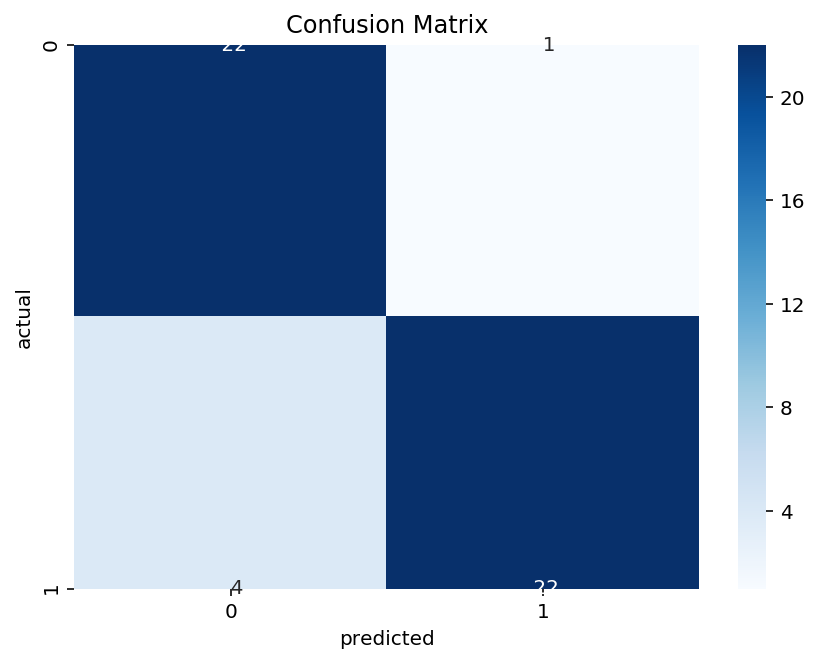

Text(0.5, 1.0, 'AUC = 0.90')

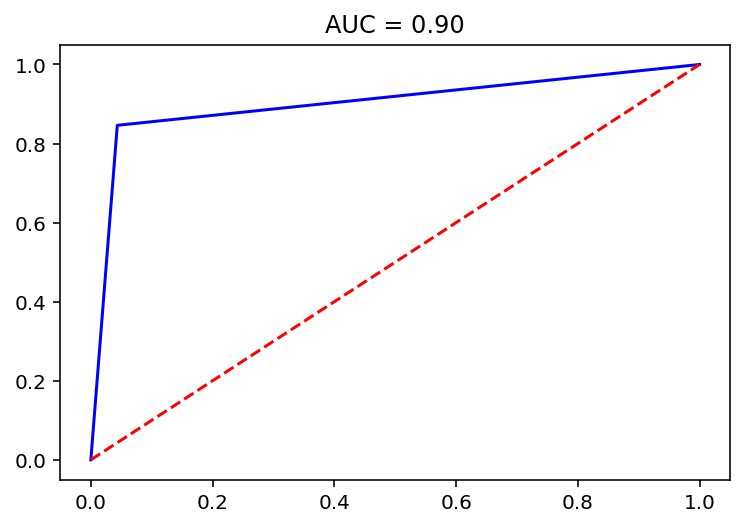

In [31]:
# Medición del rendimiento de los modelos; exactitud, exhaustividad, F1, Auc y matriz de confusión.
print("Logistic Regression with Bagging Training Score: ", bag.score(X_train_nm, y_train_nm))
print("Logistic Regression with Bagging Testing Score: ", bag.score(X_test_nm, y_test_nm))

y_test_pred = bag.predict(X_test_nm)
y_train_pred = bag.predict(X_train_nm)
cm = confusion_matrix(y_test_nm, y_test_pred)
false_positive_rate, recall, thresholds = roc_curve(y_test_nm, y_test_pred) # el area bajo la curva
roc_auc = auc(false_positive_rate, recall)
    
print("- Nombre del Modelo: {} \n" .format(bag.__class__.__name__) , "\n - Precisión: {} |" 
        .format(accuracy_score(y_test_nm, y_test_pred)), 
        "\n - Exactitud: {} |" .format(precision_score(y_test_nm, y_test_pred)), 
        "\n - Exhaustividad: {} |" .format(recall_score(y_test_nm, y_test_pred)), 
        "\n - F1: {} |" .format(f1_score(y_test_nm, y_test_pred)), 
        "\n - AUC: {} |\n" .format(auc(false_positive_rate, recall)),
        "\n - Matriz de confusion: \n {} \n" .format(cm))

plt.figure(figsize=(7,5))
sns.heatmap(cm,  cmap= 'Blues', annot=True, fmt='3')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

plot(false_positive_rate, recall, 'b') # imprimir el ratio
plot([0, 1], [0, 1], 'r--') # difinir el ratio entre 0 y 1
title('AUC = %0.2f' % roc_auc)

In [32]:
# Guardamos la Medición del rendimiento de los modelos en una tabla.
report_table_1 = ['Logistic Regression with Bagging NearMiss', bag_lr_grid.best_params_,
                  bag.score(X_train_nm, y_train_nm), bag.score(X_test_nm, y_test_nm), recall_score(y_test_nm, y_test_pred),
                 f1_score(y_test_nm, y_test_pred), auc(false_positive_rate, recall)]

##### Decision Tree with Bagging

En los árboles de decisión se construyen diagramas de construcciones lógicas, muy similares a los sistemas de predicción basados en reglas, que sirven para representar y categorizar una serie de condiciones que ocurren de forma sucesiva, para la resolución de un problema.

In [33]:
# Selección de parámetros de DT con la función "GridSearchCV"
dt = DecisionTreeClassifier()

grid_param = dict(criterion=['gini','entropy'],max_depth= np.arange(1, 15))

# establecemos la validación cruzado con 2 divisiones, los parámetros y el uso de núcleos de memoria.
bag_dt_grid = GridSearchCV(bag, grid_param, cv = 2, n_jobs = -1, return_train_score= True)

#train grid model
bag_dt_grid.fit(X_train_nm, y_train_nm)

GridSearchCV(cv=2,
             estimator=BaggingClassifier(base_estimator=LogisticRegression(C=1000.0),
                                         max_samples=0.9, n_estimators=100),
             n_jobs=-1,
             param_grid={'max_samples': [0.1, 0.5, 0.7, 0.9, 1.0],
                         'n_estimators': [100, 250, 500, 1000]},
             return_train_score=True)

In [34]:
# Mejores parámetros
print("Best Parameters for Bagging Classifier: ", bag_dt_grid.best_params_)

Best Parameters for Bagging Classifier:  {'max_samples': 1.0, 'n_estimators': 100}


In [35]:
# Construcción del modelo Bagging
dt = DecisionTreeClassifier(max_depth= bag_dt_grid.best_params_['max_depth']
                                ,criterion= bag_dt_grid.best_params_['criterion'])

bag = BaggingClassifier(dt, n_estimators=100, max_samples=0.9, 
                        bootstrap=True, n_jobs=-1, random_state=0) # bootstrap=True Para Bagging
bag.fit(X_train_nm, y_train_nm)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.9,
                  n_estimators=100, n_jobs=-1, random_state=0)

Decision Tree with Bagging Training Score:  1.0
Decision Tree with Bagging Testing Score:  1.0
- Nombre del Modelo: BaggingClassifier 
 
 - Precisión: 1.0 | 
 - Exactitud: 1.0 | 
 - Exhaustividad: 1.0 | 
 - F1: 1.0 | 
 - AUC: 1.0 |
 
 - Matriz de confusion: 
 [[23  0]
 [ 0 26]] 



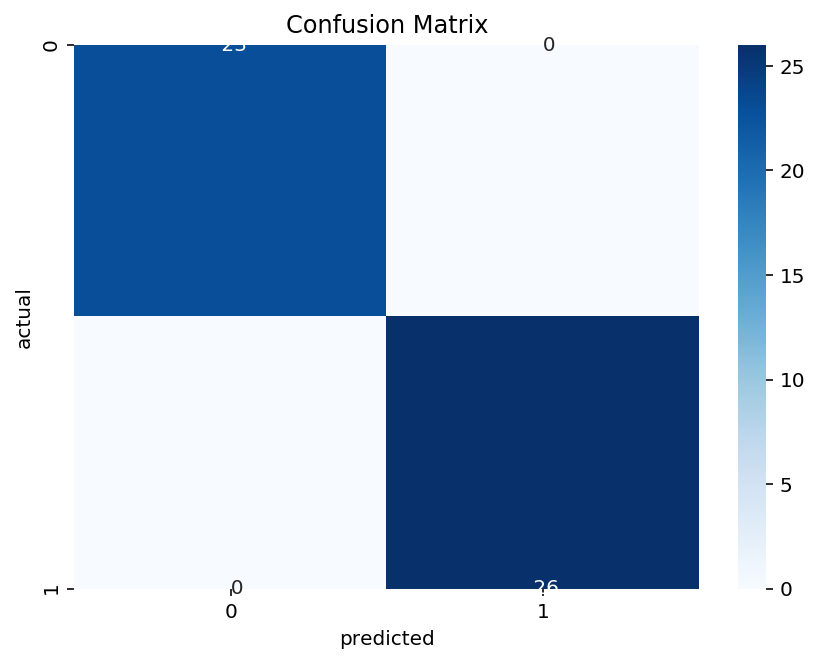

Text(0.5, 1.0, 'AUC = 1.00')

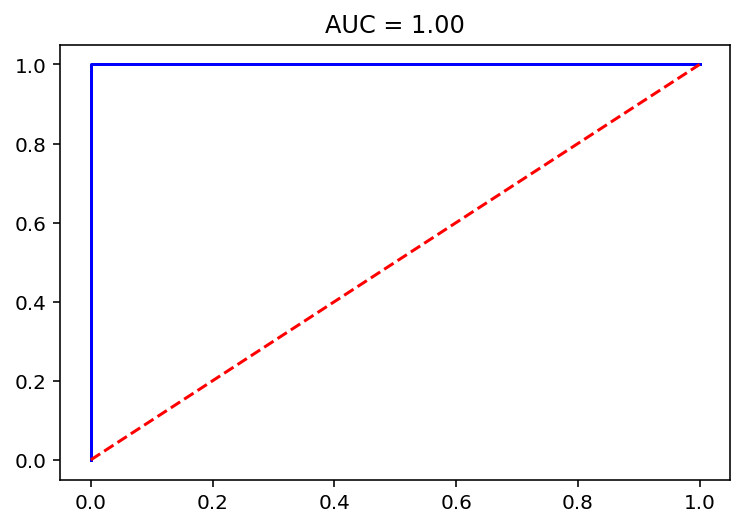

In [36]:
# Medición del rendimiento de los modelos; exactitud, exhaustividad, F1, Auc y matriz de confusión.
print("Decision Tree with Bagging Training Score: ", bag.score(X_train_nm, y_train_nm))
print("Decision Tree with Bagging Testing Score: ", bag.score(X_test_nm, y_test_nm))

y_test_pred = bag.predict(X_test_nm)
y_train_pred = bag.predict(X_train_nm)
cm = confusion_matrix(y_test_nm, y_test_pred)
false_positive_rate, recall, thresholds = roc_curve(y_test_nm, y_test_pred) # el area bajo la curva
roc_auc = auc(false_positive_rate, recall)
    
print("- Nombre del Modelo: {} \n" .format(bag.__class__.__name__) , "\n - Precisión: {} |" 
        .format(accuracy_score(y_test_nm, y_test_pred)), 
        "\n - Exactitud: {} |" .format(precision_score(y_test_nm, y_test_pred)), 
        "\n - Exhaustividad: {} |" .format(recall_score(y_test_nm, y_test_pred)), 
        "\n - F1: {} |" .format(f1_score(y_test_nm, y_test_pred)), 
        "\n - AUC: {} |\n" .format(auc(false_positive_rate, recall)),
        "\n - Matriz de confusion: \n {} \n" .format(cm))

plt.figure(figsize=(7,5))
sns.heatmap(cm,  cmap= 'Blues', annot=True, fmt='3')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

plot(false_positive_rate, recall, 'b') # imprimir el ratio
plot([0, 1], [0, 1], 'r--') # difinir el ratio entre 0 y 1
title('AUC = %0.2f' % roc_auc)

In [37]:
# Guardamos la Medición del rendimiento de los modelos en una tabla.
report_table_2 = ['Decision Tree with Bagging NearMiss', bag_dt_grid.best_params_,
                  bag.score(X_train_nm, y_train_nm), bag.score(X_test_nm, y_test_nm), recall_score(y_test_nm, y_test_pred),
                 f1_score(y_test_nm, y_test_pred), auc(false_positive_rate, recall)]

##### Random Forest Classifier with Bagging


In [38]:
# Selección de parámetros de RF con la función "GridSearchCV"
rf = RandomForestClassifier()

grid_param = dict(max_depth=[1,3,5,7,9,15], 
                  n_estimators= [100,250,500],criterion=['gini', 'entropy'])

# establecemos la validación cruzado con 2 divisiones, los parámetros y el uso de núcleos de memoria.
bag_rf_grid = GridSearchCV(bag, grid_param, cv = 2, n_jobs = -1, return_train_score= True)

#train grid model
bag_rf_grid.fit(X_train_nm, y_train_nm)

GridSearchCV(cv=2,
             estimator=BaggingClassifier(base_estimator=RandomForestClassifier(),
                                         random_state=0),
             n_jobs=-1,
             param_grid={'max_samples': [0.1, 0.5, 0.7, 0.9, 1.0],
                         'n_estimators': [100, 250, 500, 1000]},
             return_train_score=True)

In [39]:
# Mejores parámetros 
print("Best Parameters for Bagging Classifier: ", bag_rf_grid.best_params_)

Best Parameters for Bagging Classifier:  {'max_samples': 0.5, 'n_estimators': 100}


In [40]:
# Construcción del modelo Bagging
rf = RandomForestClassifier(n_estimators= rf_grid.best_params_['n_estimators']
                                , max_depth= rf_grid.best_params_['max_depth']
                                ,criterion = rf_grid.best_params_['criterion'])

bag = BaggingClassifier(rf,bootstrap=True) # bootstrap=True Para Bagging
bag.fit(X_train_nm, y_train_nm)

BaggingClassifier(base_estimator=RandomForestClassifier(), max_samples=0.7,
                  n_estimators=250, n_jobs=-1, random_state=0)

Random Forest Classifier with Bagging Training Score:  0.9823008849557522
Random Forest Classifier with Bagging Testing Score:  0.9591836734693877
- Nombre del Modelo: BaggingClassifier 
 
 - Precisión: 0.9591836734693877 | 
 - Exactitud: 1.0 | 
 - Exhaustividad: 0.9230769230769231 | 
 - F1: 0.9600000000000001 | 
 - AUC: 0.9615384615384616 |
 
 - Matriz de confusion: 
 [[23  0]
 [ 2 24]] 



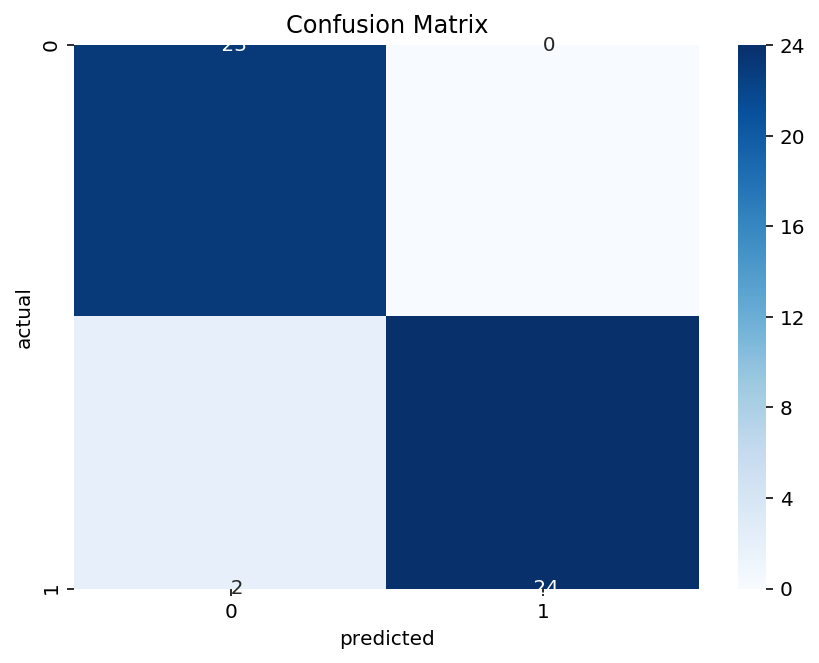

Text(0.5, 1.0, 'AUC = 0.96')

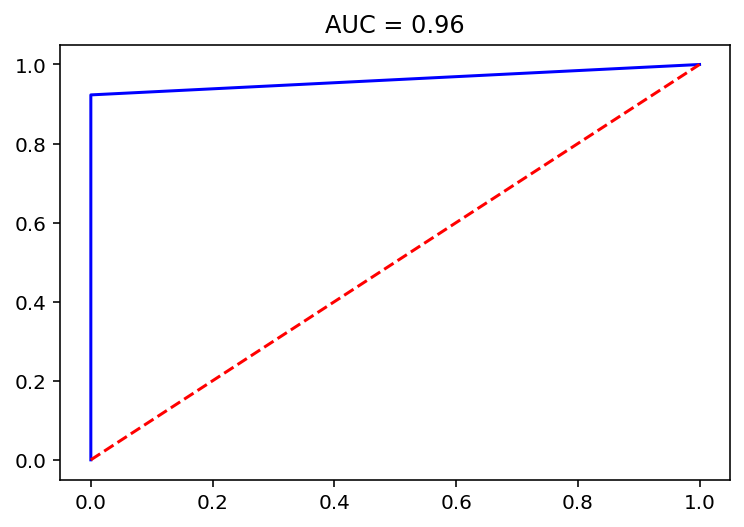

In [41]:
# Medición del rendimiento de los modelos; exactitud, exhaustividad, F1, Auc y matriz de confusión.
print("Random Forest Classifier with Bagging Training Score: ", bag.score(X_train_nm, y_train_nm))
print("Random Forest Classifier with Bagging Testing Score: ", bag.score(X_test_nm, y_test_nm))

y_test_pred = bag.predict(X_test_nm)
y_train_pred = bag.predict(X_train_nm)
cm = confusion_matrix(y_test_nm, y_test_pred)
false_positive_rate, recall, thresholds = roc_curve(y_test_nm, y_test_pred) # el area bajo la curva
roc_auc = auc(false_positive_rate, recall)
    
print("- Nombre del Modelo: {} \n" .format(bag.__class__.__name__) , "\n - Precisión: {} |" 
        .format(accuracy_score(y_test_nm, y_test_pred)), 
        "\n - Exactitud: {} |" .format(precision_score(y_test_nm, y_test_pred)), 
        "\n - Exhaustividad: {} |" .format(recall_score(y_test_nm, y_test_pred)), 
        "\n - F1: {} |" .format(f1_score(y_test_nm, y_test_pred)), 
        "\n - AUC: {} |\n" .format(auc(false_positive_rate, recall)),
        "\n - Matriz de confusion: \n {} \n" .format(cm))

plt.figure(figsize=(7,5))
sns.heatmap(cm,  cmap= 'Blues', annot=True, fmt='3')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()


plot(false_positive_rate, recall, 'b') # imprimir el ratio
plot([0, 1], [0, 1], 'r--') # difinir el ratio entre 0 y 1
title('AUC = %0.2f' % roc_auc)

In [42]:
# Guardamos la Medición del rendimiento de los modelos en una tabla.
report_table_3 = ['Random Forest Classifier with Bagging NearMiss', bag_rf_grid.best_params_,
                  bag.score(X_train_nm, y_train_nm), bag.score(X_test_nm, y_test_nm), recall_score(y_test_nm, y_test_pred),
                 f1_score(y_test_nm, y_test_pred), auc(false_positive_rate, recall)]

In [43]:
# Mostrar la Medición del rendimiento de los modelos en una tabla.
report_table = pd.DataFrame(list(zip(report_table_1,
             report_table_2, report_table_3))).transpose()

In [44]:
report_table.columns = ['Model Name', 'Model Parameter', 'Training Score', 'Testing Score', "Exhaustividad", "F1", "AUC"]
report_table.index = report_table['Model Name']
report_table.head(15)

,Model Name,Model Parameter,Training Score,Testing Score,Exhaustividad,F1,AUC
Model Name,,,,,,,
Logistic Regression with Bagging NearMiss,Logistic Regression with Bagging NearMiss,"{'max_samples': 0.9, 'n_estimators': 100}",0.938053,0.897959,0.846154,0.897959,0.901338
Decision Tree with Bagging NearMiss,Decision Tree with Bagging NearMiss,"{'max_samples': 1.0, 'n_estimators': 100}",1,1,1,1,1
Random Forest Classifier with Bagging NearMiss,Random Forest Classifier with Bagging NearMiss,"{'max_samples': 0.5, 'n_estimators': 100}",0.982301,0.959184,0.923077,0.96,0.961538


In [45]:
# guardamos los resultados
report_table.to_csv('Bagging With NearMiss.csv')

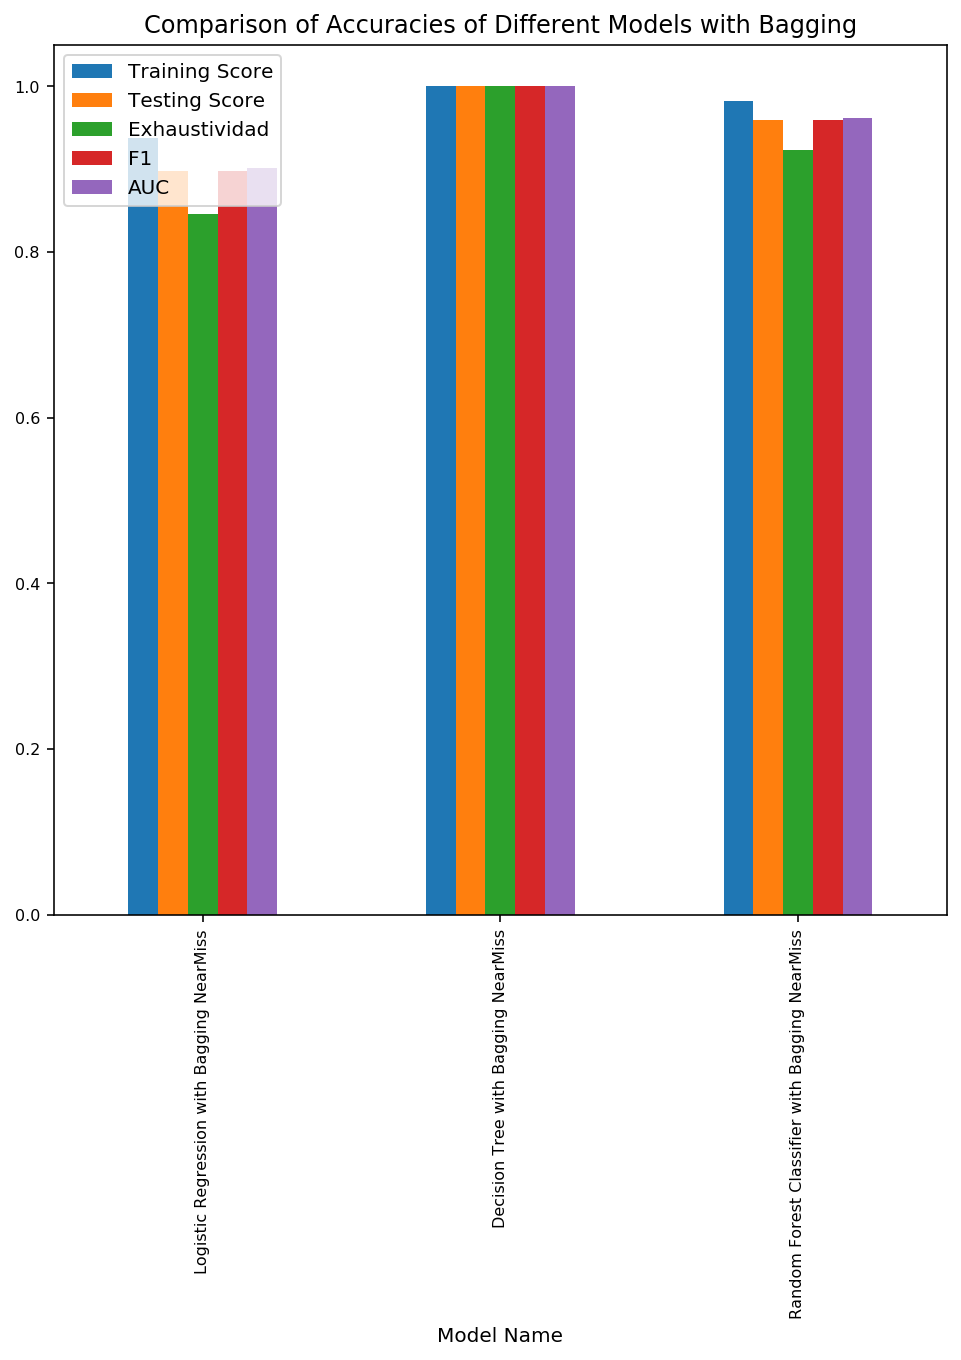

In [46]:
ax = report_table[['Model Name', 'Model Parameter', 'Training Score', 'Testing Score', "Exhaustividad", "F1", "AUC"]].plot(kind='bar',
            title = "Comparison of Accuracies of Different Models with Bagging", figsize=(8, 8), fontsize = 8)
plt.show()